# **Codigo Capitulo 10**

### Importación de librerías

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense
import cv2
import pandas as pd
import random
from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np


c:\Users\chris\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\__init__.py:177: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Lectura del data set

Se lee el data set que se construyó realizando conducción manual con un Time step de 100  a una velocidad de 20 km.

In [2]:
image_data = pd.read_csv('image_data2.csv')
print(image_data.shape)
print(image_data['Image Name'].nunique())
image_data['image_path'] = './train_images2/' + image_data['Image Name']
image_paths_wb = image_data['image_path'].values
steerings_wb = image_data['Angle'].values
image_data.head()

(36013, 3)
36013


,Image Name,Angle,Angle2,image_path
0,2024-06-22 19-49-32-443107.png,0.0,0,./train_images2/2024-06-22 19-49-32-443107.png
1,2024-06-22 19-49-32-550578.png,0.0,0,./train_images2/2024-06-22 19-49-32-550578.png
2,2024-06-22 19-49-32-634905.png,0.0,0,./train_images2/2024-06-22 19-49-32-634905.png
3,2024-06-22 19-49-32-718367.png,0.0,0,./train_images2/2024-06-22 19-49-32-718367.png
4,2024-06-22 19-49-32-785890.png,0.0,0,./train_images2/2024-06-22 19-49-32-785890.png


### Análisis de la distribución del data set

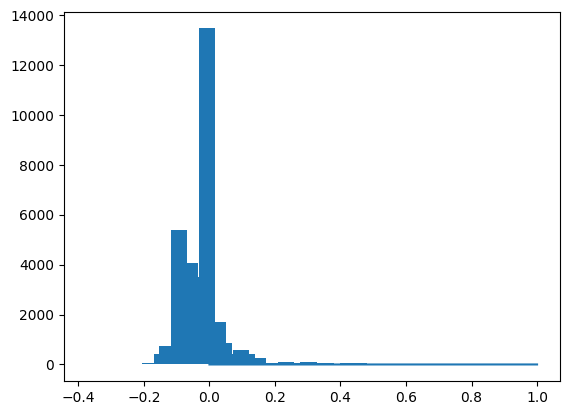

In [3]:
## Creamos un histograma de 50 bins con base en el ángulo de giro
num_bins = 50
hist, bins = np.histogram(image_data['Angle'], num_bins)
center = (bins[:-1]+ bins[1:]) * 0.5
plt.bar(center, hist, width=0.05)
plt.plot((np.min(image_data['Angle']), np.max(image_data['Angle'])))

Como vemos en la imagen anterior, el data set se encuentra desbalanceado dado que casi todos sus valores de ángulo de conducción están cerca de 0. Buscado que nuestro modelo sea bueno también prediciendo ángulos un poco más grandes vamos a balancear el data set. Para esto realizaremos un sampling del data set original, buscando que los ángulos más alejados del 0 tengan una mayor probabilidad de ser tomados.

In [4]:
def calculate_sampling_probability(angle):
    return np.abs(angle) + 0.01  # Añadir un pequeño valor para que 0 tenga una probabilidad mayor a 0

# Calcular las probabilidades
image_data['sampling_prob'] = image_data['Angle'].apply(calculate_sampling_probability)

# Normalizar las probabilidades para que sumen 1
total_prob = image_data['sampling_prob'].sum()
image_data['sampling_prob'] /= total_prob

# Realizar el muestreo basado en las probabilidades calculadas
sampled_df = image_data.sample(frac=0.7, weights='sampling_prob', random_state=1)

# Se remueve la columna adicional generada para el sampling
sampled_df = sampled_df.drop(columns=['sampling_prob'])

# Resetear el índice del DataFrame resultante si es necesario
sampled_df = sampled_df.reset_index(drop=True)

In [5]:
image_data = sampled_df

Graficamos nuevamente el data set por medio de un histrograma

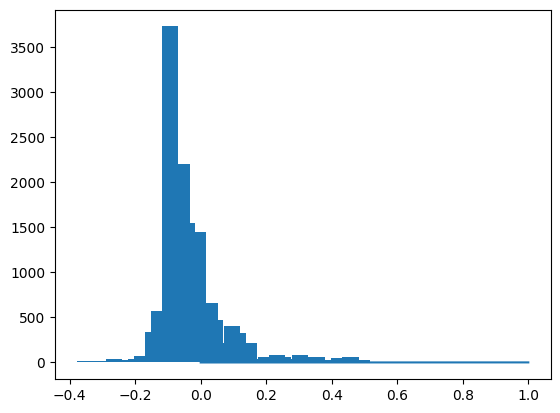

In [6]:
num_bins = 50
hist, bins = np.histogram(image_data['Angle'], num_bins)
center = (bins[:-1]+ bins[1:]) * 0.5
plt.bar(center, hist, width=0.05)
plt.plot((np.min(image_data['Angle']), np.max(image_data['Angle'])))

Analizando el histograma anterior, podemos evidenciar que la distribución mejoró un poco y ya tenemos un mayor % de datos lejos del ángulo de conducción 0.

In [7]:
## Creamos un array con las imágenes y otro con los ángulos correspondientes
image_paths_wb = image_data['image_path'].values
steerings_wb = image_data['Angle'].values
print(image_paths_wb.shape)
print(steerings_wb.shape )

(14405,)
(14405,)


Vemos que quedamos con alrededor de 25.000 imágenes para entrenar nuestro modelo.

### Construcción de los data sets

Dado que tebnemos una gran cantidad de muestras, dejaremos solo el 10% para validación, buscando así contar con una gran cantidad de datos para entrenar la red neuronal.

In [8]:
## Realizamos el split del data set entre entrenamiento y valdiación. Añanimos shuffle para garantizar que las imágenes en ambos data sets sean representativas de todo el circuito
X_train, X_valid, y_train, y_valid = train_test_split(image_paths_wb, steerings_wb, test_size=0.1, random_state=6, shuffle=True)
print('Training Samples: {}\nValid Samples: {}'.format(len(X_train), len(X_valid)))

Training Samples: 12964
Valid Samples: 1441


Validamos que la dsitribución de los ángulos de conducción sea similar en ambos data sets para que no haya sesgos

Text(0.5, 1.0, 'Validation set')

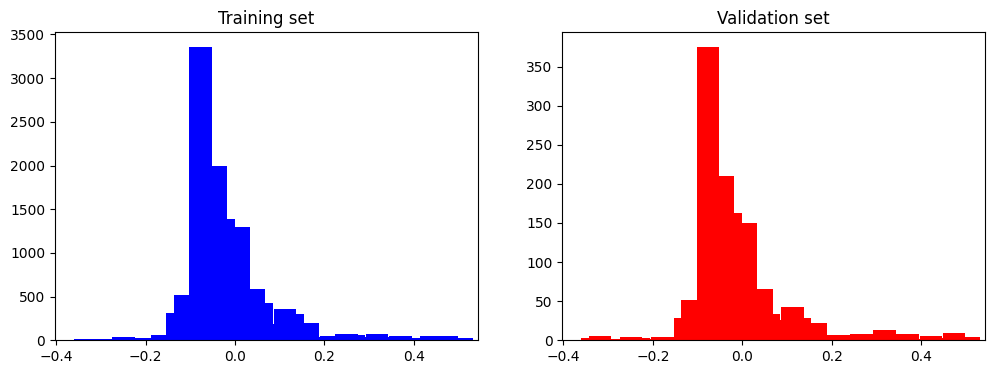

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Validation set')

Decidimos no implementar data augmentation en el modelo final, dado que estaba siendo muy costoso computacionalmente y no estaba incrementando significativamente el desempeño de los modelos

In [10]:
list_images_train = [np.expand_dims(mpimg.imread(X_train[i]),axis=-1) for i in range(len(X_train))]
list_images_valid = [np.expand_dims(mpimg.imread(X_valid[i]),axis=-1) for i in range(len(X_valid))]

### Elaboración del generador de bachts

In [11]:
def batch_generator_wb(list_images, steering_ang, batch_size, istraining):
    while True:
        # se generan dos listas en las que se guardarán las imágenes y los ángulos
        batch_img = []
        batch_steering = []
        # Realizamos un ciclo con base en el número de imágenes a generar en cada batch
        for i in range(batch_size):
            # Se seleccionan las imágenges y los ángulos aleatoriamente con base en un índice random
            random_index = random.randint(0, len(list_images) - 1)
            im = list_images[random_index]
            steering = steering_ang[random_index]
            # Se agregan las imágenes y ángulos selecccionados a la lista
            batch_img.append(im)
            batch_steering.append(steering)
        ## Usamos yield para que funcione como un generador
        yield (np.asarray(batch_img), np.asarray(batch_steering))

### Creación del modelo

Creamos la arquitectura del modelo convolucional basados en el Nvidia Model. Realizando las siguiente consideraciones:
- Learnign rate: 0.001. Este valor se obtuvo realizando pruebas entre varios valores y viendo cual generaba los mejores resultados.
- Loss: MSE. Usamos el MSE para penalizar más las diferencias más grandes que podrían llevar a que el vehículo se salga de la pista.
- Optimizer: ADAM. Usualmente tiene un buen desempeño con este tipo de redes.


In [12]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam

## NVIDIA Model
model = Sequential()
model.add(Conv2D(24, (5, 5), strides=(2, 2), input_shape=(66, 200, 4), activation='elu'))
model.add(Conv2D(36, (5, 5), strides=(2, 2), activation='elu'))
model.add(Conv2D(48, (5, 5), strides=(2, 2), activation='elu'))
model.add(Conv2D(64, (3, 3), activation='elu'))
model.add(Conv2D(64, (3, 3), activation='elu'))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(100, activation='elu'))
model.add(Dense(50, activation='elu'))
model.add(Dense(10, activation='elu'))
model.add(Dense(1))

optimizer = Adam(learning_rate=0.0005) # Este valor se obtuvo realizando pruebas entre varios valores y viendo cual generaba los mejores resultados
model.compile(loss='mse', optimizer=optimizer) # Usamos el MSE para penalizar más las diferencias más grandes que podrían llevar a que el vehí

c:\Users\chris\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [13]:
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 31, 98, 24)     │         2,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 47, 36)     │        21,636 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 5, 22, 48)      │        43,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 3, 20, 64)      │        27,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 1, 18, 64)      │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 18, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │       115,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           510 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 252,819 (987.57 KB)

 Trainable params: 252,819 (987.57 KB)

 Non-trainable params: 0 (0.00 B)

None


Creamos una función de Early Stop para que el modelo se detanga si lleva más de 5 epoca sin lograr mejoras significativas sobre el data set de validación.

In [14]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True) #Se restauran los pesos del modelo al mejor resultado logrado sobre la data de validación

Implementamos un Scaler sobre el ángulo de conducción, buscando que el modelo logre converger más rápidamente y evitar problemas de desvanecimiento del gradiente.

In [15]:
from sklearn.preprocessing import MinMaxScaler
# Se entrena el scaler
scaler = MinMaxScaler()
y_train_scaled = scaler.fit_transform(y_train.reshape(-1, 1))
# Se utiliza el scaler para ajustar también los ángulos de validación
y_valid_scaled = scaler.transform(y_valid.reshape(-1, 1))

### Entrenamiento de  la red neuronal.

In [16]:
history = model.fit(batch_generator_wb(list_images_train, y_train_scaled, int(len(y_train_scaled)/5), False), ## Usamos el generador para entrenar con el 10% de los datos en cada época
                              steps_per_epoch=100, ## Se realizan 60 ajustes de gradiente por época, esto se cálculo iterativamente
                              epochs=100, ## Entrenamos durante 20 épocas debido a capacidad computacional
                              validation_data=batch_generator_wb(list_images_valid, y_valid_scaled, int(len(y_valid_scaled)), False), ## Usamos el generador para evaluar con el 50% de los datos de valdiación en cada época
                              validation_steps=1, # Evaluamos en 5 pasos
                              verbose=1,
                              shuffle = 1, ## Realiamos shuffle para garantizar que las imágenes no se generen en orden
                    callbacks=[early_stopping])

Epoch 1/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - loss: 0.2155 - val_loss: 0.0125
Epoch 2/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - loss: 0.0129 - val_loss: 0.0088
Epoch 3/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - loss: 0.0105 - val_loss: 0.0084
Epoch 4/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - loss: 0.0093 - val_loss: 0.0069
Epoch 5/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - loss: 0.0086 - val_loss: 0.0075
Epoch 6/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - loss: 0.0078 - val_loss: 0.0066
Epoch 7/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - loss: 0.0073 - val_loss: 0.0054
Epoch 8/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - loss: 0.0066 - val_loss: 0.0044
Epoch 9/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - loss: 0.0061 - val_loss: 0.0062
Epoch 10/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - loss: 0.0057 - val_loss: 0.0035
Epoch 11/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - loss: 0.0052 - val_loss: 0.0041
Epoch 12/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - loss: 0.0049 - val_lo

### Evaluación del modelo

A continuación graficamos la función de pérdida a lo largo de las épocas, para evaluar si el entrenamientno se relizó correctamente.

Text(0.5, 0, 'Epoch')

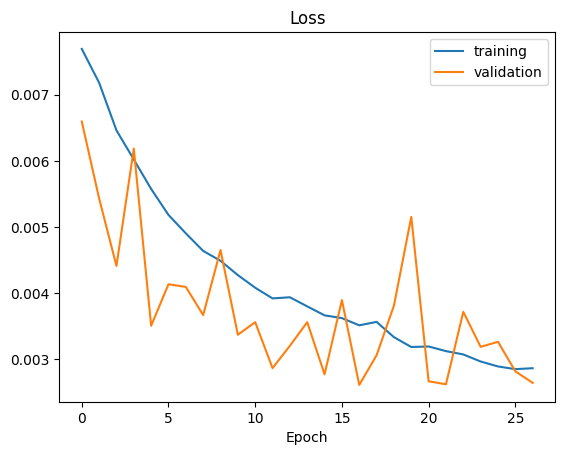

In [20]:
plt.plot(history.history['loss'][5:]) ## Dejamos las primeras 5 épocas por fuera de la gráfica dado que normalmente presentan valores muy altos que impiden analizar correctamente la gráfica
plt.plot(history.history['val_loss'][5:])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')

Analizando la gráfica anterior, podemos concluir que el entrenamiento del modelo fue correcto, dado que la curva de validación y de entrenamiento son similares y cercancas, lo cual quiere decir que no hay presencia de sobre ajuste y la pérdida logra llegar a un mínimo al final del proceso. ( No se corrieron más épocas debido al largo tiempo de entrenamiento)

### Exportación del modelo 

Se exporta el modelo

In [21]:
model.save('model.h5')

Se exporta el escaler

In [22]:
import joblib
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']